## Exploratory Data Analysis
### Time series analysis

**Objetivo**: O objetivo deste notebook é desenvolver a fase de data quality check. Nesta iremos explorar a qualidade e estado dos dados:

* Data profiling;
    * Médias;
    * Outliers;
    * Distribuição;
    * Frequência de observações;
* Forecastability (Análise de autocorrelação);
* Sazonalidade e tendência;
* Estacionaridade;

**Conclusões**:

* Outliers: Temos outliers baixos, que remetem aos primeiros 3 meses dos dados, onde os valores estão todos abaixo de R$ 90, enquanto todo o resto da série acima deste valor.
* Distribuição:
    * Distribuição original: Bimodal, considerando os outliers citados anteiormente.
    * Distribuição sem outliers: Não passou nos testes de normalidade, porém é aproximada;

### 1.0 Imports

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
#from pandas_profiling import ProfileReport

# Time Series Libraries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import RobustScaler
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf  # Plot de Autocorrelação - Moving Averages
from statsmodels.graphics.tsaplots import plot_pacf  # Plot de Autocorrelação - Auto Regressive
from pmdarima.arima.utils import ndiffs 
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats import shapiro, normaltest, kstest

### 2.0 Data loading

In [33]:
stock_df = pd.read_csv("../data/raw/raw_stock_prices.csv")
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].apply(lambda x: x.date())
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df = stock_df.rename(columns={"Close": "preco", "Date": "data"})

### 3.0 Data profilling


In [34]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    720 non-null    datetime64[ns]
 1   preco   720 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.4 KB


In [35]:
stock_df.head()

,data,preco
0,2020-03-02,102.989998
1,2020-03-03,101.750000
2,2020-03-04,103.099998
3,2020-03-05,98.790001
4,2020-03-06,94.400002


In [36]:
#timeseries_report = ProfileReport(stock_df.set_index("Date"), ts_mode=False, title="EDA de Fundo de Índice BOVA11")
#timeseries_report.to_file("../reports/BOVA11_report.html")

#### 3.1 Distribuição

In [37]:
stock_df.describe()

,preco
count,720.000000
mean,104.056823
std,11.752078
min,61.139999
25%,98.247499
50%,106.040001
75%,112.080002
max,125.750000


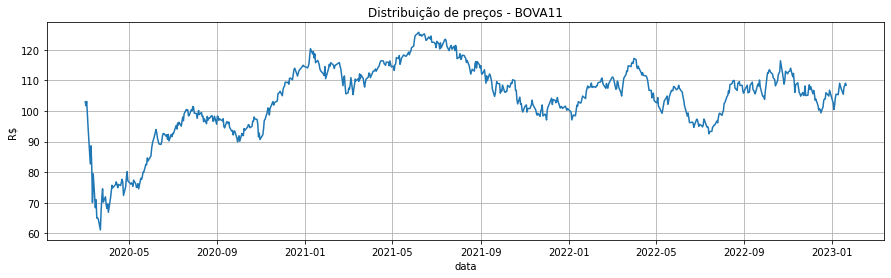

In [38]:
fig, axs = plt.subplots(figsize=(15, 4))
sns.lineplot(
    data=stock_df,
    x="data",
    y="preco",
    ax=axs,
)

axs.set_title("Distribuição de preços - BOVA11")
axs.set_ylabel("R$")

plt.grid()
plt.show()


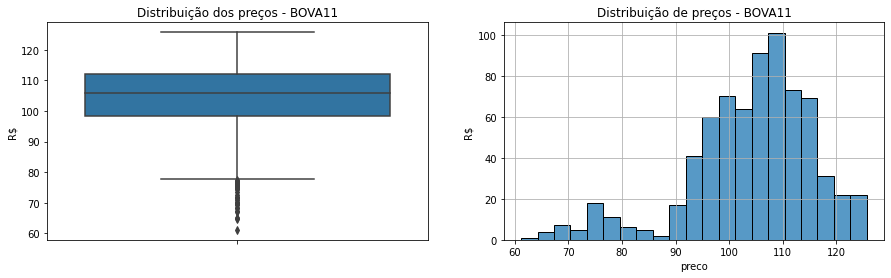

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.boxplot(
    data=stock_df,
    y="preco",
    ax=axs[0],
)
axs[0].set_title("Distribuição dos preços - BOVA11")
axs[0].set_ylabel("R$")

sns.histplot(
    data=stock_df,
    x="preco",
    ax=axs[1],
)

axs[1].set_title("Distribuição de preços - BOVA11")
axs[1].set_ylabel("R$")

plt.grid()
plt.show()


In [40]:
# Teste na distribuição original
print("Shapiro Test")
statistics, p_value = shapiro(stock_df['preco'])
print(f"Statistics: {statistics}\n P-valor: {p_value}")

print("K-S Test")
statistics, p_value = kstest(stock_df['preco'], 'norm')
print(f"Statistics: {statistics}\n P-valor: {p_value}")

print("D’Agostino’s K-squared test")
statistics, p_value = normaltest(stock_df['preco'])
print(f"Statistics: {statistics}\n P-valor: {p_value}")

Shapiro Test
Statistics: 0.9387546181678772
 P-valor: 1.2469038344143567e-16
K-S Test
Statistics: 1.0
 P-valor: 0.0
D’Agostino’s K-squared test
Statistics: 105.51793559788781
 P-valor: 1.2220005855455668e-23


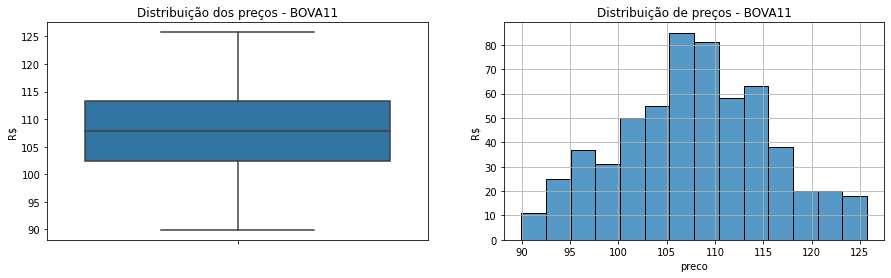

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.boxplot(
    data=stock_df[stock_df['data'] > pd.to_datetime('2020-09-01')],
    y="preco",
    ax=axs[0],
)
axs[0].set_title("Distribuição dos preços - BOVA11")
axs[0].set_ylabel("R$")

sns.histplot(
    data=stock_df[stock_df['data'] > pd.to_datetime('2020-09-01')],
    x="preco",
    ax=axs[1],
)

axs[1].set_title("Distribuição de preços - BOVA11")
axs[1].set_ylabel("R$")

plt.grid()
plt.show()


In [ ]:

# Teste na distribuição original
print("Shapiro Test")
statistics, p_value = shapiro(stock_df[stock_df['data'] > pd.to_datetime('2020-09-01').date()]['preco'])
print(f"Statistics: {statistics}\n P-valor: {p_value}")

print("K-S Test")
statistics, p_value = kstest(stock_df[stock_df['data'] > pd.to_datetime('2020-09-01').date()]['preco'], 'norm')
print(f"Statistics: {statistics}\n P-valor: {p_value}")

print("D’Agostino’s K-squared test")
statistics, p_value = normaltest(stock_df[stock_df['data'] > pd.to_datetime('2020-09-01').date()]['preco'])
print(f"Statistics: {statistics}\n P-valor: {p_value}")

Shapiro Test
Statistics: 0.9910222291946411
 P-valor: 0.0011587348999455571
K-S Test
Statistics: 1.0
 P-valor: 0.0
D’Agostino’s K-squared test
Statistics: 9.319473667874743
 P-valor: 0.009468953981182807


##### OBS:
Existem outliers baixos, que se referem aos primeiros meses de observação dos dados (Até junho), onde os valores estão abaixo de R$ 90 e nunca mais voltaram a este nível. Isso faz com que tenhamos uma distrição bimodal. Provavelmente será melhor desconsiderar este período ou aumentar o histórico para atrás a fim de que haja mais observações neste nível.

Mesmo removendo os outliers baixos a distribuição não se tornou normal, mas está próxima.

In [43]:
stock_mod_df= stock_df[stock_df['data'] > pd.to_datetime('2020-09-01')]

#### 4.0 Sazonalidade, tendência

#### 4.1 Decomposição manual

In [47]:
stock_mod_df['day_name'] = stock_mod_df['data'].apply(lambda x: x.day_name())
stock_mod_df['day_of_month'] = stock_mod_df['data'].apply(lambda x: x.day)
stock_mod_df['month'] = stock_mod_df['data'].apply(lambda x: x.month)
stock_mod_df['day_of_week'] = stock_mod_df['data'].apply(lambda x: x.day_of_week)
stock_mod_df['quarter'] = stock_mod_df['data'].apply(lambda x: x.quarter)


/tmp/ipykernel_26514/2279740507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_mod_df['day_name'] = stock_mod_df['data'].apply(lambda x: x.day_name())
/tmp/ipykernel_26514/2279740507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_mod_df['day_of_month'] = stock_mod_df['data'].apply(lambda x: x.day)
/tmp/ipykernel_26514/2279740507.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [51]:
stock_mod_df.head()

,data,preco,day_of_week,day_of_month,month,quarter,day_name
128,2020-09-02,98.150002,2,2,9,3,Wednesday
129,2020-09-03,96.959999,3,3,9,3,Thursday
130,2020-09-04,97.419998,4,4,9,3,Friday
131,2020-09-08,96.800003,1,8,9,3,Tuesday
132,2020-09-09,97.500000,2,9,9,3,Wednesday


##### 4.1.1 Por dia da semana

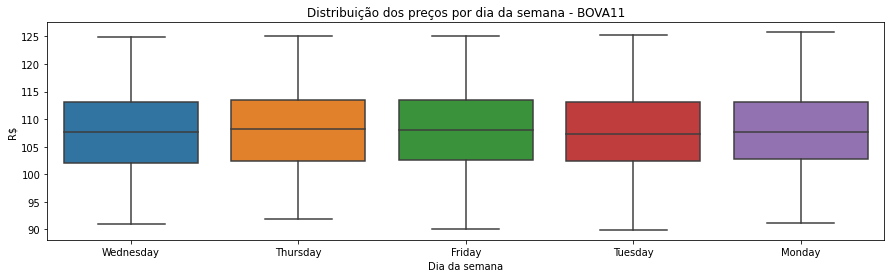

In [55]:
fig, axs = plt.subplots(figsize=(15, 4))
sns.boxplot(
    data=stock_mod_df,
    x='day_name',
    y="preco",
    ax=axs,
)
axs.set_title("Distribuição dos preços por dia da semana - BOVA11")
axs.set_ylabel("R$")
axs.set_xlabel("Dia da semana")
plt.show()


##### 4.1.2 Por dia do mês

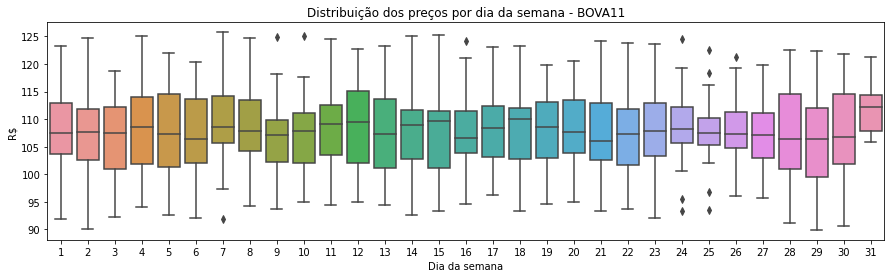

In [57]:
fig, axs = plt.subplots(figsize=(15, 4))
sns.boxplot(
    data=stock_mod_df,
    x='day_of_month',
    y="preco",
    ax=axs,
)
axs.set_title("Distribuição dos preços por dia da semana - BOVA11")
axs.set_ylabel("R$")
axs.set_xlabel("Dia da semana")
plt.show()


#### 4.2 Seasonal Decompose

In [56]:
#decomposition = seasonal_decompose(stock_mod_df.set_index("data")['preco'])